In [2]:
import numpy as np
from time import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import pdspy.modeling as modeling
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.animation import FuncAnimation
import os
import pickle

%matplotlib inline

In [3]:
param_names = ["T_star","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]

# get all model data
with open ('../grid_metadata/corefull.txt', 'rb') as fp:
    core= pickle.load(fp)
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)
    
dictionary=np.load("../grid_metadata/dictionary.npy")

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(np.log10(xvals),cube[16])
plt.xlabel("log(Wavelength) - microns").set_fontsize(16)
plt.ylabel("log(Flux Density) - Janskys").set_fontsize(16)
plt.tick_params(labelsize=12)
plt.title("example SED generated by pdspy",pad=20).set_fontsize(20)
plt.show()

In [ ]:
dictionary[16]

In [5]:
# get all model data
with open ('../grid_metadata/corefull.txt', 'rb') as fp:
    core= pickle.load(fp)[100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))[:,100:500]
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)[100:500]

# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan

In [6]:
# subtracting from the seds each sample mean
seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

done in 0.059s


In [ ]:
colors=plt.cm.viridis(np.linspace(0.1,1,10))
plt.figure(figsize=(12,10))
plt.plot(np.log10(xvals),np.mean(cube,axis=0),c='k',label="mean, grid SEDs",lw=3)
#plt.plot(np.log10(xvals),np.std(cube,axis=0),c='k',label="standard deviation, grid SEDs",linestyle="--")
for i in range(10):
    plt.plot(np.log10(xvals),(17+(15-2.5*i))*eigenseds[i]-(5*(i+1)),c=colors[i],label="principal component #"+str(i))
plt.xlabel("log(Wavelength) - microns").set_fontsize(16)
plt.ylabel("log(Flux Density) + offset").set_fontsize(16)
plt.tick_params(axis='x',labelsize=12)
plt.tick_params(axis='y',left=False,labelleft=False)
plt.legend(bbox_to_anchor=(1.02, 1))
plt.show()

In [ ]:
# get all model data
with open ('../grid_metadata/corefull.txt', 'rb') as fp:
    core= pickle.load(fp)
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube2 = np.array(pickle.load(fp))
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)

In [ ]:
plt.figure(figsize=(16,12))
for i in range(3850):
    plt.plot(np.log10(xvals),cube[i],c='b',alpha=0.03)
plt.xlabel("log(Wavelength) - microns").set_fontsize(16)
plt.ylabel("log(Flux Density) - Janskys").set_fontsize(16)
plt.tick_params(labelsize=12)
plt.show()

In [ ]:
for i in (5,18,47,60):
    print(dictionary[i])
    plt.figure(figsize=(12,9))
    plt.loglog(xvals,10**cube2[i])
    plt.ylim(1e-70,1e5)
    plt.ylabel("Flux Density - Janskys",fontsize=16)
    plt.xlabel("Wavelength - microns",fontsize=16)
    plt.show()

In [ ]:
plt.figure(figsize=(16,12))
for i in range(3850):
    plt.loglog(xvals,10**cube[i],c='b',alpha=0.03)
plt.xlabel("Wavelength - microns").set_fontsize(16)
plt.ylabel("Flux Density - Janskys").set_fontsize(16)
plt.tick_params(labelsize=12)
plt.show()

In [ ]:
inf=[]
for i in range(3850):
    if -np.inf in cube[i]:
        inf.append(i)

In [ ]:
dictionary[1]['logM_env']

In [ ]:
pars=[]
for j in range(len(param_names)):
    pars.append([])
    for i in range(len(inf)):
        pars[j].append(dictionary[i][param_names[4]])
        

In [ ]:
np.array(pars).shape

In [29]:
def sedcomp_anim(model,ncomp=40,nfeat=400):
    
    fig,ax= plt.subplots(figsize=(12,9))
    ax.plot(np.log10(xvals)[0:nfeat], cube[model][0:nfeat], c='black',label="pdspy SED")
        
    coeffs=pca.transform(seds_msub[model].reshape(1,-1)) 
    reconst=[]
    for j in range(ncomp):
        reconst.append(np.dot(coeffs[0][0:j+1],eigenseds[0:j+1,0:nfeat]) +\
                       pca.mean_[0:nfeat]+np.nanmean(nancube[model]))
    
    line, = ax.plot(np.log10(xvals)[0:nfeat], reconst[0], c='b')
    
    def animate(i):
        label="number of components = {0}".format(int(i//1))
        line.set_ydata(reconst[int(i//1)])
        ax.set_xlabel("log of λ (μm)",fontsize=16)
        if -np.inf in cube[model]:
            ax.set_ylim(-45,10)
        ###ax.annotate(str(i),(1.8,-4),size=60)
        ax.set_ylabel("log of Flux Density (mJy)",fontsize=16)
        ax.set_title("reconstructed SED of model #"+str(model)+" against pdspy SED, ncomp="+str(int(i//1)+1))
        return line,ax

    anim=FuncAnimation(fig,animate,frames=np.arange(0,ncomp,0.25),interval=1)
    anim.save("../talk/"+str(model)+"_reconst.gif", dpi=72, writer="imagemagick")

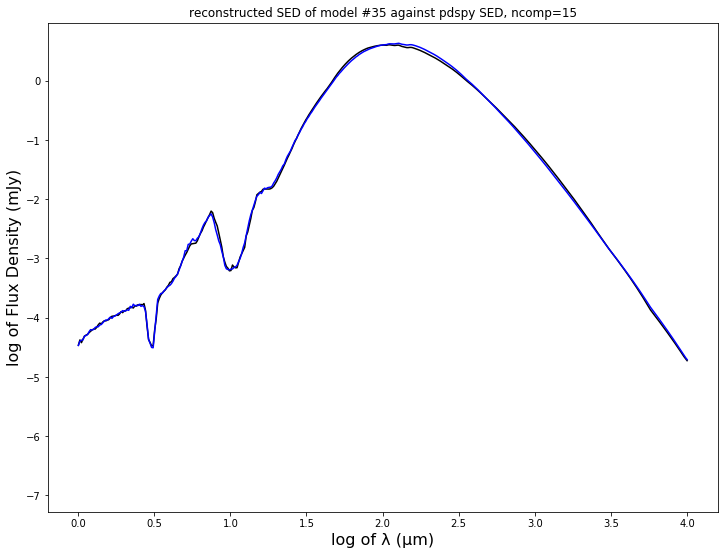

In [30]:
sedcomp_anim(35,ncomp=15)

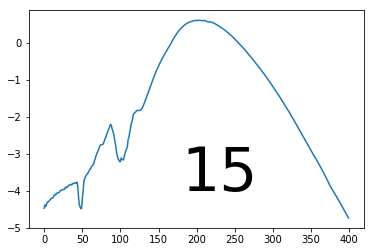

In [25]:
plt.plot(cube[35])
plt.annotate("15",(1.8,-4),size=60)
plt.show()